In [84]:
pwd

'D:\\Programming'

In [85]:
datetime.now()

datetime.datetime(2021, 5, 1, 20, 15, 23, 348086)

In [1]:
# First we will try the univariate forecasting and then we'll go for multivariate forecasting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web
from datetime import datetime

In [2]:
start = datetime(2010,1,1)
end = datetime(2020,1,1)

rel = web.DataReader('RELIANCE.NS','yahoo',start,end)

In [3]:
rel = rel[['Adj Close','Volume']]

In [4]:
rel.head(3)

,Adj Close,Volume
Date,,
2010-01-04,485.824005,35372156.0
2010-01-05,483.655701,9872785.0
2010-01-06,491.470398,10933743.0


### First of all we'll go for univariate forecasting using RNN-LSTM

In [5]:
rel_uni = rel['Adj Close']
rel_uni.columns = ['close']

In [6]:
train, test = rel_uni[:int(len(rel_uni)*0.8)],rel_uni[int(len(rel_uni)*0.8):]

In [7]:
len(train), len(test)

(1969, 493)

In [8]:
"""
We will make a model that takes in the previous 14 days data and then predicts the 15th day data or we can say the close 
of the 15th day.

We'll make arrays for the train data as well as the test data and then we'll predict the values on the test inputs and compare 
with the actual values. 
"""

"\nWe will make a model that takes in the previous 14 days data and then predicts the 15th day data or we can say the close \nof the 15th day.\n\nWe'll make arrays for the train data as well as the test data and then we'll predict the values on the test inputs and compare \nwith the actual values. \n"

In [16]:
# Converting the series in to the array form so that out model has no issue and stops throwing out some errors

train_arr = np.array(train)
train_arr = train_arr.reshape(-1,1)


test_arr = np.array(test)
test_arr = test_arr.reshape(-1,1)

train_arr.shape, test_arr.shape

((1969, 1), (493, 1))

In [17]:
# Scaling the data for its use in the network
scaler = MinMaxScaler()
scaler.fit(train_arr)
train_scaled = scaler.transform(train_arr)

#similarily scaling the data of the test data
test_scaled = scaler.transform(test_arr)

In [26]:
# Seperating the train and test into packets of input and corresponding outputs
trainx = []
trainy = []

testx = []
testy = []

n_inputs = 14 # we choose to look for previous 14 days to predict the 15th days close price

for i in range(n_inputs, len(train_scaled)):
    trainx.append(np.array(train_scaled[i-n_inputs:i]))
    trainy.append(train_scaled[i])

for i in range(n_inputs, len(test_scaled)):
    testx.append(np.array(test_scaled[i-n_inputs:i]))
    testy.append(test_scaled[i])


In [29]:
trainx = np.array(trainx)
trainy = np.array(trainy)

testx = np.array(testx)
testy = np.array(testy)

In [30]:
trainx.shape,trainy.shape,testx.shape,testy.shape

((1955, 14, 1), (1955, 1), (479, 14, 1), (479, 1))

In [39]:
"""
Building a LSTM model so as to predic the stock prices of the stock the next day. Lets keep in mind that we have 
chosen to work over the raw data of the close price and haven't taken into account for the non-stationarity fo the 
nature of the data
"""
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_inputs,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(x=trainx, y=trainy, epochs=100, verbose=1)

Epoch 1/100
62/62 [==============================] - 7s 55ms/step - loss: 0.0204
Epoch 2/100
62/62 [==============================] - 3s 54ms/step - loss: 6.6136e-04
Epoch 3/100
62/62 [==============================] - 3s 55ms/step - loss: 5.7936e-04
Epoch 4/100
62/62 [==============================] - 3s 54ms/step - loss: 5.2211e-04
Epoch 5/100
62/62 [==============================] - 3s 53ms/step - loss: 4.6786e-04
Epoch 6/100
62/62 [==============================] - 3s 56ms/step - loss: 5.3375e-04
Epoch 7/100
62/62 [==============================] - 4s 59ms/step - loss: 4.6429e-04
Epoch 8/100
62/62 [==============================] - 4s 60ms/step - loss: 4.6183e-04
Epoch 9/100
62/62 [==============================] - 4s 59ms/step - loss: 3.5819e-04
Epoch 10/100
62/62 [==============================] - 4s 61ms/step - loss: 4.5521e-04
Epoch 11/100
62/62 [==============================] - 3s 50ms/step - loss: 5.0030e-04
Epoch 12/100
62/62 [==============================] - 3s 52ms/step 

62/62 [==============================] - 3s 47ms/step - loss: 1.7901e-04
Epoch 95/100
62/62 [==============================] - 3s 46ms/step - loss: 1.6791e-04
Epoch 96/100
62/62 [==============================] - 3s 47ms/step - loss: 1.6320e-04
Epoch 97/100
62/62 [==============================] - 3s 49ms/step - loss: 1.9027e-04: 0s - loss: 1.
Epoch 98/100
62/62 [==============================] - 3s 49ms/step - loss: 1.6980e-04
Epoch 99/100
62/62 [==============================] - 3s 53ms/step - loss: 1.4447e-04
Epoch 100/100
62/62 [==============================] - 3s 50ms/step - loss: 1.5922e-04


In [48]:
predy_arr = model.predict(testx)

In [62]:
predY_df = scaler.inverse_transform(predy_arr)

In [71]:
predy_ls = []
for i in range(len(predY_df)):
    predy_ls.append(predY_df[i][0])

In [75]:
test[-479:].shape

(479,)

In [76]:
len(predy_ls)

479

### Now we have the test values and the predicted values, lets combine them in a dataframe

In [77]:
compare_df = pd.DataFrame({"actual":test[-479:], "pred":predy_ls})

In [78]:
compare_df

,actual,pred
Date,,
2018-01-15,925.851868,932.736572
2018-01-16,900.295044,931.508911
2018-01-17,901.806946,899.023682
2018-01-18,897.124756,906.369751
2018-01-19,908.440125,902.297852
...,...,...
2019-12-26,1495.554810,1513.842041
2019-12-27,1522.151855,1485.263672
2019-12-30,1523.977661,1523.656982


<AxesSubplot:xlabel='Date'>

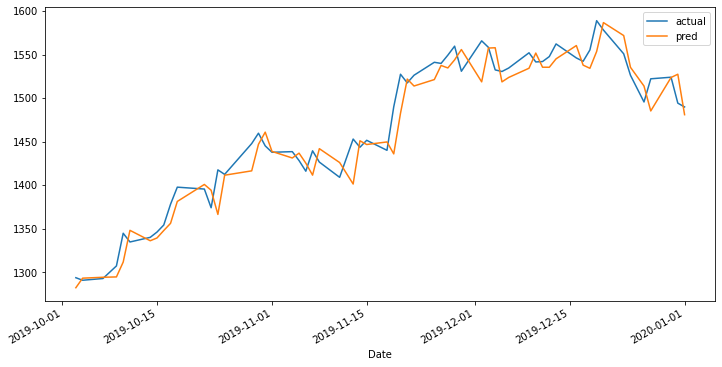

In [81]:
compare_df[-60:].plot()

In [82]:
from statsmodels.tools.eval_measures import rmse

In [ ]:
rmse(compare_df['actual'], compare_df['pred'])

## This is still dissapointing, can't work with this shit predictions

In [ ]:
"""
Moving on further we'll try the prophet from facebook... lets see
"""